In [13]:
%load_ext autoreload 
%autoreload 2

import scipy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from age_balance_analysis import util
from tqdm.notebook import tqdm

sns.set_style("whitegrid")

DATA_PATH = Path("../data/lysine_vacule_knockouts")
LABELLING_DATA_PATH = DATA_PATH / "2024-02-19_MS_proteins_EO_3.tsv"
FRACTIONATED_DATA_PATH = DATA_PATH / "2024-02-25_MS_proteins_EO_6.tsv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t").rename(
    columns={"PG.ProteinGroups": "gene"}
)
unfractionated_df["time_h"] = unfractionated_df.time_min / 60.0

## Calculate the growth rates

For all experiments with several time points. Use the `growth_dilution` column to get the biomass over time.

condition strain           pulse_type  \
experiment                                                         
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_time_points  growth_rate  
experiment                                              
9                     30                3     0.357593  
10                    30                3     0.354332  
11                    37                3     0.340428  
12                    37                3     0.345937

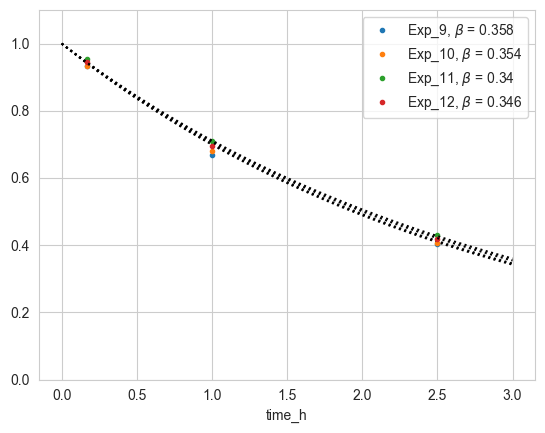

In [15]:
metadata_df = unfractionated_df[
    ["experiment", "condition", "strain", "pulse_type", "temp_celsius", "time_h"]
].drop_duplicates()
metadata_df = metadata_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().time_h.reset_index().set_index("experiment")
metadata_df.rename(columns={"time_h": "num_time_points"}, inplace=True)
metadata_df = metadata_df[metadata_df.num_time_points > 1]

# Use the Biomass data to calculate the growth rates
fig, ax = plt.subplots(1, 1)
growth_rates = {}
for idx, group_df in unfractionated_df.groupby(["experiment"]):
    biomass_df = group_df.groupby(["time_h", "replicate"]).growth_dilution.mean().reset_index()
    if biomass_df.shape[0] > 1:
        linreg_result = scipy.stats.linregress(biomass_df.time_h, np.log(biomass_df.growth_dilution))
        growth_rates[idx] = -linreg_result.slope
        biomass_df.plot(x="time_h", y="growth_dilution", style=".", label=f"Exp_{idx[0]}, $\\beta$ = {growth_rates[idx]:.3g}", ax=ax)
        t_range = np.linspace(start=0, stop=3, num=50)
        ax.plot(t_range, np.exp(-growth_rates[idx]*t_range), 'k:')
ax.set_ylim(0, 1.1)
metadata_df = metadata_df.join(pd.Series(growth_rates, name="growth_rate"), on="experiment")
metadata_df

## Use the trapezoid approximation to calculate the mean ages

In [16]:
result_list = []

filtered_df = unfractionated_df[(unfractionated_df.channel == "K1") & (unfractionated_df.precursor_no > 20)]

for experiment, row in metadata_df.iterrows():
    # there are no replicates in experiments with time courses
    _df = filtered_df[filtered_df.experiment == experiment].pivot(index=["gene", "replicate"], columns="time_h", values="labelling").dropna()
    for idx in tqdm(_df.index):
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[idx, :].to_numpy()
        
        mean_age = util.calc_mean_age_trapezoid(xdata, ydata, row.growth_rate)

        tau_lbs = np.array([5e-3, 5e-3])
        tau_ubs = np.array([10,  10])
        popt, pcov, mse = util.fit_taus(xdata, ydata, measured_pool_index=1, tau_lbs=tau_lbs, tau_ubs=tau_ubs)

        result_list.append((experiment, idx, mean_age, row.growth_rate, popt[0] + popt[1]))

result_df = pd.DataFrame(result_list, columns=["experiment", "index", "mean_age", "growth_rate", "mean_age_ksm"])
result_df["lysine_pool"] = result_df.mean_age - 1.0/result_df.growth_rate

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

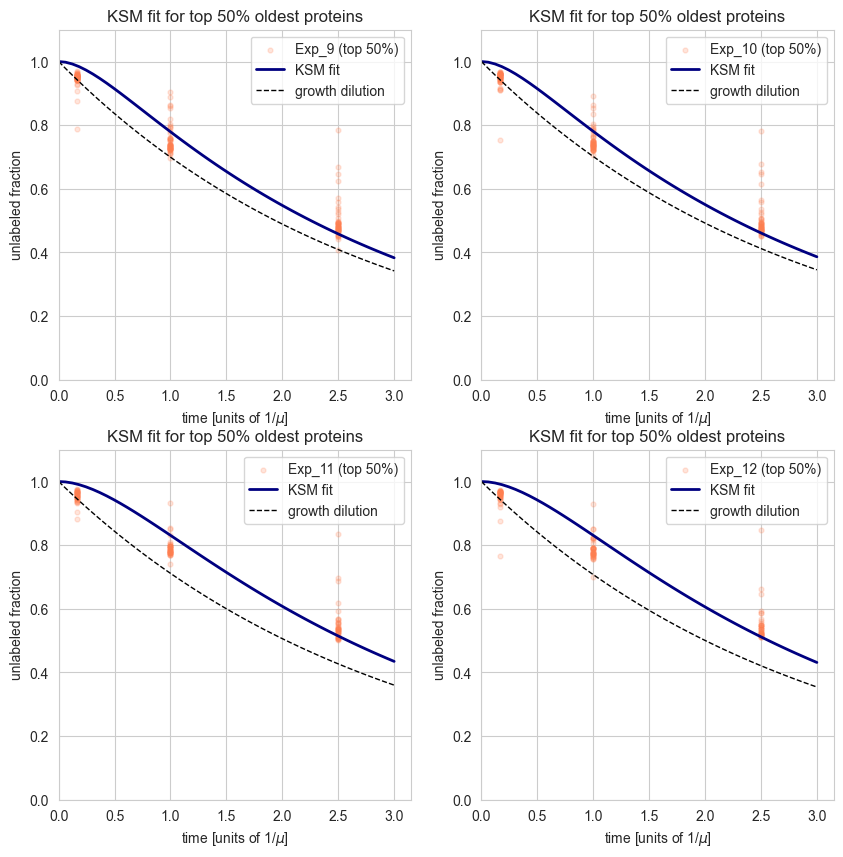

In [17]:
# select the top 50% oldest proteins (assuming all of them are not degraded), and fit a KSM to find the lysine pool size
thresholds = result_df.groupby("experiment").median("mean_age").mean_age.rename("threshold")
result_thresh_df = result_df.join(thresholds, on="experiment")
result_thresh_df = result_thresh_df[result_thresh_df.mean_age > result_thresh_df.threshold]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

popt_dict = {}
pcov_dict = {}

for ax, (experiment, group_df) in zip(axs.flat, result_thresh_df.groupby("experiment")):
    _df = filtered_df[(filtered_df.experiment == experiment)].set_index(["gene", "replicate"])
    xdata = _df.loc[group_df["index"].to_list(), "time_h"].to_numpy()
    ydata = _df.loc[group_df["index"].to_list(), "labelling"].to_numpy()

    growth_rate = group_df.growth_rate.iat[0]
    pool_2 = 1./growth_rate
    tau_lbs = np.array([5e-3, pool_2 - 1e-5])
    tau_ubs = np.array([10,  pool_2 + 1e-5])
    popt, pcov, mse = util.fit_taus(xdata, ydata, measured_pool_index=1, tau_lbs=tau_lbs, tau_ubs=tau_ubs)
    lysine_pool_mean = popt[0]
    lysine_pool_std = np.sqrt(pcov[0, 0])

    popt_dict[experiment] = popt
    pcov_dict[experiment] = pcov

    t_range = np.linspace(start=0, stop=3, num=50)
    ax.scatter(xdata, ydata, color="coral", s=12, label=f"Exp_{experiment} (top 50%)", alpha=0.2)

    ydata_pred = util.f_labelling(t_range, 1, *popt)
    ax.plot(t_range, ydata_pred, '-', color="navy", linewidth=2, label="KSM fit")

    ydata_growth = np.exp(-t_range * growth_rate)
    ax.plot(t_range, ydata_growth, '--', color="black", linewidth=1, label="growth dilution")

    ax.set_xlim(0, None)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("unlabeled fraction")
    ax.set_xlabel("time [units of 1/$\\mu$]")
    ax.set_title("KSM fit for top 50% oldest proteins")
    ax.legend()

In [18]:
metadata_df = metadata_df.join(pd.Series({k: v[0] for k, v in popt_dict.items()}, name="lysine_pool_mean"))
metadata_df = metadata_df.join(pd.Series({k: v[0, 0] for k, v in pcov_dict.items()}, name="lysine_pool_std"))
display(metadata_df[["lysine_pool_mean", "lysine_pool_std"]])

lysine_pool_mean  lysine_pool_std
experiment                                   
9                   0.300366         0.003788
10                  0.299278         0.004016
11                  0.507462         0.013336
12                  0.521160         0.016898

## Use the lysine pools to calculate mean age and transit times

In [19]:
import sympy

tau1, tau2 = sympy.symbols("τ_1 τ_2")
t = sympy.symbols("t")
f1 = sympy.symbols("f_1")
M = sympy.Matrix([[-1/tau1, 0], [1/tau2, -1/tau2]])
f1_formula = ((M*t).exp()[-1, :] @ np.ones((2, 1)))[0]

def find_tau2(_t: float, _f1: float, _tau1: float) -> float:
    values = {t: _t, f1: _f1, tau1: _tau1}
    try:
        solution = float(sympy.nsolve((f1_formula - f1).subs(values), tau2, 1.0))
        return solution
    except ValueError:
        return np.nan

In [20]:
first_time_point = filtered_df.time_h.min()

data = []
for experiment, meta_row in metadata_df.iterrows():
    # there are no replicates in experiments with time courses
    _df = filtered_df[(filtered_df.experiment == experiment) & (filtered_df.time_h == first_time_point)]
    for data_row in tqdm(_df.itertuples(), total=_df.shape[0], desc=f"Experiment {experiment}"):
        sol = find_tau2(first_time_point, data_row.labelling, meta_row.lysine_pool_mean)
        data.append((experiment, data_row.gene, data_row.replicate, data_row.labelling, sol))
        
result2_df = pd.DataFrame(data=data, columns=["experiment", "gene", "replicate", "labelling", "tau2"])
result2_df = result2_df.join(metadata_df, on="experiment")

Experiment 9:   0%|          | 0/103 [00:00<?, ?it/s]

Experiment 10:   0%|          | 0/98 [00:00<?, ?it/s]

Experiment 11:   0%|          | 0/78 [00:00<?, ?it/s]

Experiment 12:   0%|          | 0/77 [00:00<?, ?it/s]

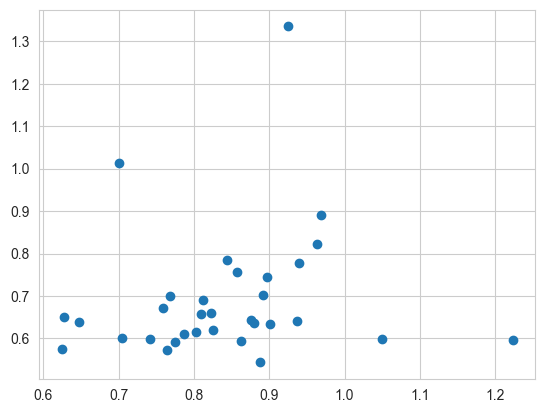

In [22]:
_df = result2_df.groupby(["gene", "temp_celsius"]).mean("tau2").reset_index().pivot(index="gene", columns="temp_celsius", values="tau2")
plt.scatter(_df[30], _df[37])

In [23]:
result2_df.groupby(["gene", "temp_celsius"]).mean("tau2").reset_index().pivot(index="gene", columns="temp_celsius", values="tau2")

temp_celsius        30        37
gene                            
AAT2          0.810029       NaN
ACC1          1.049554  0.597718
ACO1          0.829439       NaN
ACO2          0.790370       NaN
ACS2          0.600415       NaN
...                ...       ...
XRN1          0.689808       NaN
YDR341C       0.666104       NaN
YEF3          0.825072  0.620577
YHR020W       0.697145       NaN
YNL247W       0.671221       NaN

[113 rows x 2 columns]